# "An RL Approach for Inventory Management (Part 7)"

> Tabular Monte-Carlo Prediction
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/InventoryManagement7.png
- categories: [Inventory_Management,   Markov_Decision_Process,   MC]
- show_tags: true

In [ ]:
# hide
# based on 0^mc_simple_inventory_mrp_KE.ipynb

## 1 Overview of the Reinforcement Learning Approach

So far, we always had a *model* for the environment. This model came in the form of transition probabilities. It is often the case in the real world that we do not have these probabilties. We simply get individual experiences of next state and reward, given we take a specific action in a specific state. However, we still need a way to obtain the optimal value function or the optimal policy. There are algorithms available for this need. We have now entered the subfield of Reinforcement Learning. When we have a model (as in previous parts) the subfield is called Dynamic Programming or Approximate Dynamic Programming.

Note that we can use Reinforcement Learning even if we may have the option to obtain a model. Sometimes the state space is so large that obtaining a model is hard or the computational aspects become intractable. 

## 2 RL for Prediction

Let us repeat some points related to *prediction*:
- *prediction* is the problem of estimating the *value function* of an MDP given a policy $\pi$
- the equivalent problem is to estimate the value function of the $\pi$-implied MRP

In this project we choose to work with MRPs, rather than MDPs, depending on the latter point. The relationship with the MRP environment is such that the:
- Environment is available as an interface that serves up individual experiences of (next state, reward), given a current state. Note the absence of an action.
- Environment might the *real* or *simulated*.

We define the agent's experience with the environment as follows:
  - *atomic experience*
    - agent receives a single experience of (next state, reward), given current state
  - *trace experience*
    - starting from state $S_0$, repeated interactions with the environment leading to a sequence of atomic experiences

The RL prediction problem is the estimate the value function, given a stream of atomic experiences or a stream of trace experiences.

An MRP's value function is:

$$
V(s) = \mathbb E[G_t|S_t=s]
$$

for all $s \in \mathcal N$, for all $t=0,1,2,...$

where the return $G_t$ for each $t=0,1,2,...$ is defined as:

$$
\begin{aligned}
G_t &= R_{t+1}+\gamma \cdot R_{t+2}+\gamma^2 \cdot R_{t+3}+... \\
&= \sum_{i=t+1}^\infty \gamma ^{i-t-1} \cdot R_i \\
&= R_{t+1}+\gamma \cdot G_{t+1}
\end{aligned}
$$

This infinite sum is true even if a trace experience terminates, say at $t=T$ ($S_T \in \mathcal T$) because we take $R_i=0$ for all $i>T$.

In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
base_dir = root_dir + '/Rao_CME241/RL-book'

Mounted at /content/gdrive


In [2]:
!python --version

Python 3.7.15


In [3]:
# hide
base_dir

'/content/gdrive/My Drive/Rao_CME241/RL-book'

In [4]:
# hide
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [5]:
# hide
# sys.path.insert(0, f"{base_dir}/gen_utils"); sys.path
sys.path.append(f"{base_dir}"); sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Rao_CME241/RL-book']

We make use of the approach and code used in http://web.stanford.edu/class/cme241/.

In [6]:
from __future__ import annotations
from typing import Tuple, Sequence, Iterator, List, TypeVar, Generic, overload, Mapping, Iterable
from dataclasses import dataclass
from abc import ABC, abstractmethod
import itertools as it
import inspect
import math

In [7]:
# hide
# from rl.markov_decision_process_ANNO import NonTerminal
from rl.markov_process_ANNO import TransitionStep, S, MarkovProcess
from rl.function_approx_ANNO import Tabular
# from rl.approximate_dynamic_programming_ANNO import ValueFunctionApprox
# from rl.iterate_ANNO import accumulate, last
import rl.iterate_ANNO as iterate
# from rl.monte_carlo_ANNO import mc_prediction
from rl.distribution_ANNO import Choose

In [8]:
# hide
from rl.book3_github2.simple_inventory_mrp import (
    SimpleInventoryMRPFinite,
    InventoryState)
from rl.book11_github10.prediction_utils_ANNO import (
#     mrp_episodes_stream, 
#     fmrp_episodes_stream, 
    mc_finite_prediction_equal_wts,
    mc_finite_equal_wts_correctness,
    mc_finite_learning_rate_correctness)

Let us setup our Inventory problem again:

In [9]:
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0
si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

In [10]:
# hide
inspect.getmro(SimpleInventoryMRPFinite)

(rl.book3_github2.simple_inventory_mrp.SimpleInventoryMRPFinite,
 rl.markov_process_ANNO.FiniteMarkovRewardProcess,
 rl.markov_process_ANNO.FiniteMarkovProcess,
 rl.markov_process_ANNO.MarkovRewardProcess,
 rl.markov_process_ANNO.MarkovProcess,
 abc.ABC,
 typing.Generic,
 object)

Next we look at how we want to implement the simulation of experiences as stated above in code. The essential element is the `TransitionStep`:



In [11]:
@dataclass(frozen=True)
class TransitionStep(Generic[S]): #. s -> s'r   (atomic experience)
    state: NonTerminal[S]
    next_state: State[S]
    reward: float
    
    def add_return(self, γ: float, return_: float) -> ReturnStep[S]:
        return ReturnStep( #. s -> s'r
            self.state,
            self.next_state,
            self.reward,
            return_=self.reward + γ*return_
        )

A `TransitionStep` instance captures an atomic experience. It carries the `state`, `next_state`, and `reward` information. The `add_return` method allows for the incorporation of return values, making use of the class `ReturnStep`:

In [12]:
@dataclass(frozen=True)
class ReturnStep(TransitionStep[S]):
    return_: float

In general, the input to an RL prediction algorithm will be either:
- a stream/sequence of atomic experiences
  - `Iterable[TransitionStep[S]]`
- a stream/sequence of trace experiences
  - `Iterable[Iterable[TransitionStep[S]]]`

As before, we make use of the class `MarkovRewardProcess`:

In [13]:
class MarkovRewardProcess(MarkovProcess[S]):
    #. transition from this state
    def transition(self, state: NonTerminal[S]) -> Distribution[State[S]]: #s'|s or s->s'
        distribution = self.transition_reward(state)
        def next_state(distribution=distribution):
            next_s, _ = distribution.sample() #.ignores reward
            return next_s
        return SampledDistribution(next_state)

    @abstractmethod
    def transition_reward(#. transition from this state
        self, 
        state: NonTerminal[S]
    ) -> Distribution[Tuple[State[S], float]]: #. s'r|s or s->s'r
        pass
    
    def simulate_reward(
        self,
        start_state_distribution: Distribution[NonTerminal[S]]
    ) -> Iterable[TransitionStep[S]]: #. sequence of atomic experiences
        state: State[S] = start_state_distribution.sample()
        reward: float = 0.
        while isinstance(state, NonTerminal):
            next_distribution = self.transition_reward(state)
            next_state, reward = next_distribution.sample()
            yield TransitionStep(state, next_state, reward) # s -> s'r
            state = next_state

    def reward_traces(
        self,
        start_state_distribution: Distribution[NonTerminal[S]]
    ) -> Iterable[Iterable[TransitionStep[S]]]: #. sequence of trace experiences
        while True:
            yield self.simulate_reward(start_state_distribution)

Our current focus is on the methods:
- `simulate_reward()`
  - operates as a step (atomic experience) generator
  - yields a sequence of (state, next state, reward) 3-tuples, i.e. a sequence of atomic experiences
- `reward_traces()`
  - operates as a trace (trace experience) generator
  - yields a sequence of trace experiences, each trace yielding a sequence of (state, next state, reward) atomic experiences
  - picks a start state $S_0$ from the provided `start_state_distribution` 

In [14]:
# hide
# mc_finite_equal_wts_correctness() <prediction_utils>
#   mc_finite_prediction_equal_wts() <prediction_utils>
#     fmrp_episodes_stream() <prediction_utils>
#       mrp_episodes_stream() <prediction_utils>
#         reward_traces() <markov_process>[MarkovRewardProcess]
#     mc_prediction() <monte_carlo>
#       returns() <returns>
#         islice() <itertools>
#         accumulate() <iterate>
#           accumulate() <itertools>
#         islice() <itertools>
#       iterate_updates() <function_approx>[FunctionApprox]
#         accumulate() <itertools>
#       last() <iterate>
#   islice() <itertools>
#   last() <itertools>

In [15]:
si_mrp.non_terminal_states

[NonTerminal(state=InventoryState(on_hand=0, on_order=0)),
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)),
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)),
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)),
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)),
 NonTerminal(state=InventoryState(on_hand=2, on_order=0))]

In [16]:
# 
# start_state_distribution
ssd = Choose(si_mrp.non_terminal_states); ssd

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.16666666666666666, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.16666666666666666}

In [17]:
# 
# atomic experience
next(si_mrp.simulate_reward(ssd))

TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0)

In [18]:
# hide
next(next(si_mrp.reward_traces(ssd)))

TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=2)), reward=-10.0)

In [19]:
# 
# let's say we need 3 traces
n_traces = 3

In [20]:
# 
# this trace generator (reward_traces()) will generate 3 atomic generators (simulate_reward())
[atom_gen for atom_gen in it.islice(si_mrp.reward_traces(ssd), n_traces)]

[<generator object MarkovRewardProcess.simulate_reward at 0x7fde24b94dd0>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7fde24b94750>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7fde24bc9150>]

In [21]:
# 
# let's say we want 4 steps/atoms for each trace
n_atoms = 4

In [22]:
trac_gen = si_mrp.reward_traces(ssd); trac_gen

<generator object MarkovRewardProcess.reward_traces at 0x7fde24bc90d0>

In [25]:
[list(it.islice(atom_gen, n_atoms)) for atom_gen in it.islice(trac_gen, n_traces)]

[[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-4.678794411714423),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-3.6787944117144233),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-0.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), reward=-2.0363832351432696)],
 [TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), reward=-2.0363832351432696),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), next_state=NonTerminal(state=InventoryS

## 3 Monte-Carlo (MC) Prediction

The Monte_Carlo (MC) prediction algorithm is a popular and simple RL algorithm which:
- performs supervised learning in an incremental way
- takes as predictor points $x$ the encountered states across the stream of input trace experiences
- takes as response points $y$ the associated returns on the trace experiences, i.e. starting from the corresponding encountered state
- predict the expected return from any state of an MRP

The function `mc_prediction()` provides this prediction:

In [26]:
def mc_prediction(
    traces: Iterable[Iterable[mp.TransitionStep[S]]],#. seq/stream of trace experiences
    approx_0: ValueFunctionApprox[S],
    γ: float,
    episode_length_tolerance: float = 1e-6
) -> Iterator[ValueFunctionApprox[S]]:
    episodes: Iterator[Iterator[mp.ReturnStep[S]]] = \
        (returns(trace, γ, episode_length_tolerance) for trace in traces)
    f = approx_0
    yield f

    for i,episode in enumerate(episodes): #.
        print(f"\repisode {i}", end="") #.
        f = iterate.last(f.iterate_updates(
            [(step.state, step.return_)] for step in episode
        ))
        yield f
    print('\n') #.

### 3.1 Setup a trace generator

The inputs to `mc_prediction()` are:
- `traces: Iterable[Iterable[mp.TransitionStep[S]]]`
  - stream/sequence of of trace experiences
  - each trace experience is a `Iterable` `TransitionStep`s

To prepare the stream of trace experiences we make use of two helper functions:
- `fmrp_episodes_stream()`
- `mrp_episodes_stream()`


In [27]:
def mrp_episodes_stream(
    mrp: MarkovRewardProcess[S],
    start_state_distribution: NTStateDistribution[S]
) -> Iterable[Iterable[TransitionStep[S]]]:
    return mrp.reward_traces(start_state_distribution)

def fmrp_episodes_stream(
    fmrp: FiniteMarkovRewardProcess[S]
) -> Iterable[Iterable[TransitionStep[S]]]:
    return mrp_episodes_stream(fmrp, Choose(fmrp.non_terminal_states))

In [28]:
# hide
# mc_finite_equal_wts_correctness() <prediction_utils>
#   mc_finite_prediction_equal_wts() <prediction_utils>
#     fmrp_episodes_stream() <prediction_utils>
#       mrp_episodes_stream() <prediction_utils>
#         reward_traces() <markov_process>[MarkovRewardProcess]
#     mc_prediction() <monte_carlo>
#       returns() <returns>
#         islice() <itertools>
#         accumulate() <iterate>
#           accumulate() <itertools>
#         islice() <itertools>
#       iterate_updates() <function_approx>[FunctionApprox]
#         accumulate() <itertools>
#       last() <iterate>
#   islice() <itertools>
#   last() <itertools>

Let us see how they behave.

In [29]:
# 
# +++study mrp_episodes_stream()

In [30]:
trac_gen1 = mrp_episodes_stream(si_mrp, ssd); trac_gen1

<generator object MarkovRewardProcess.reward_traces at 0x7fde24bc95d0>

In [31]:
list(it.islice(trac_gen1, 2))

[<generator object MarkovRewardProcess.simulate_reward at 0x7fde24bc96d0>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7fde24bc92d0>]

In [32]:
# 
# ---study mrp_episodes_stream()

In [33]:
# 
# +++study fmrp_episodes_stream()

In [34]:
trac_gen2 = fmrp_episodes_stream(si_mrp); trac_gen2

<generator object MarkovRewardProcess.reward_traces at 0x7fde24bc9750>

In [35]:
list(it.islice(trac_gen2, 2))

[<generator object MarkovRewardProcess.simulate_reward at 0x7fde24bc98d0>,
 <generator object MarkovRewardProcess.simulate_reward at 0x7fde24bc97d0>]

In [36]:
# 
# ---study fmrp_episodes_stream()

In [37]:
# hide
# +++study mc_prediction()
#     mc_prediction() <monte_carlo>
#       returns() <returns>
#         it.islice()
#         accumulate() <iterate>
#           it.accumulate()
#         it.islice()
#       iterate_updates() <function_approx>[FunctionApprox]
#         it.accumulate()
#       last() <iterate>

In [38]:
initial_vf_dict: Mapping[NonTerminal[InventoryState], float] = \
    {s: 0. for s in si_mrp.non_terminal_states}
initial_vf_dict

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.0,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.0,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.0,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.0}

In [39]:
traces: Iterable[Iterable[TransitionStep[S]]] = fmrp_episodes_stream(si_mrp)

In [40]:
n_traces = 2
n_atoms = 4
some_traces = [list(it.islice(trace, n_atoms)) for trace in it.islice(traces, n_traces)]; some_traces

[[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0)],
 [TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-4.678794411714423),
  TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=1)), reward=-3.67879

### 3.2 Calculate the returns for each state

In [41]:
# 
# +++.+++study returns()

The `returns()` function calculates the accumulated discounted rewards, $G_t$, from each state $S_t$ in a trace experience. This is done by walking backwards from the end of the trace to the start (allowing the reuse of the calculated returns) making use of

$$
G_t = R_{t+1} + \gamma \cdot G_{t+1}
$$

It makes use of `iterate.accumulate` to perform the backwards-walk, which uses `TransistionStep`s `add_return` to return a `ReturnStep`. class `ReturnStep` is derived from `TransitionStep` and it allows for the inclusion of the `return_` attribute which captures the return.

Trace experiences are of two kinds:
- *episodic trace*
  - trace experience ends in a terminal state
- *continuing trace*
  - trace experience does not terminate

An RL problem is:
- *episodic*
  - all the input trace experiences are episodic
- *continuing*
  - some of the input trace experiences are continuing

In [42]:
def returns(trace, γ, tolerance):
    trace = iter(trace)

    max_steps = round(math.log(tolerance)/math.log(γ)) if γ < 1 else None
    if max_steps is not None:
        trace = it.islice(trace, max_steps*2)

    *transitions, last_transition = list(trace)

    return_steps = iterate.accumulate(
        reversed(transitions),
        func=lambda next, curr: curr.add_return(γ, next.return_),
        initial=last_transition.add_return(γ, 0)
    )
    return_steps = reversed(list(return_steps))

    if max_steps is not None:
        return_steps = it.islice(return_steps, max_steps)

    return return_steps

In [43]:
a_trace = some_traces[0]; a_trace

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0)]

In [44]:
trace = iter(a_trace); trace

In [45]:
gamma: float = 0.9
episode_length_tolerance: float = 1e-6
max_steps = round(math.log(episode_length_tolerance)/math.log(gamma)) if gamma < 1 else None; max_steps

131

In [46]:
trace = it.islice(trace, max_steps*2); trace

In [47]:
*transitions, last_transition = list(trace)

In [48]:
transitions

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0)]

In [49]:
last_transition

TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0)

The `iterate` `accumulate()` function is a wrapper around the `itertools` `accumulate()` function. 

In [50]:
# 
# +++.+++.+++study accumulate() <iterate>

Let us investigate how the `accumulate()` function in the `itertools` module works.

In [52]:
# 
# +++.+++.+++.+++study accumulate() <itertools>

Multiply

In [53]:
my_lst = [1, 2, 3, 4, 5]

In [54]:
import operator
result = it.accumulate(my_lst, operator.mul); result

In [55]:
list(result)

[1, 2, 6, 24, 120]

Max

In [56]:
my_lst = [5, 3, 6, 2, 1, 9, 1]

In [57]:
result = it.accumulate(my_lst, max); result

In [58]:
list(result)

[5, 5, 6, 6, 6, 9, 9]

In [59]:
# 
# ---.---.---.---study accumulate() <itertools>

In [60]:
transitions # s->s'r

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0)]

In [61]:
transitions[0]

TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0)

In [62]:
last_transition

TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0)

In [63]:
list(reversed(transitions))

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0)]

In [64]:
last_transition.add_return(gamma, 0)

ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0, return_=-1.0)

In [65]:
return_steps = iterate.accumulate(
        reversed(transitions),
        func=lambda next, curr: curr.add_return(gamma, next.return_),
        initial=last_transition.add_return(gamma, 0)
    )
return_steps

In [66]:
my_return_steps = list(return_steps); my_return_steps

[ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0, return_=-1.0),
 ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0, return_=-1.9),
 ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0, return_=-2.71),
 ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0, return_=-3.439)]

In [67]:
from pprint import pprint
pprint(my_return_steps)

[ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0, return_=-1.0),
 ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0, return_=-1.9),
 ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-1.0, return_=-2.71),
 ReturnStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-1.0, return_=-3.439)]


In [68]:
# 
# ---.---.---study accumulate() <iterate>

In [69]:
# 
# ---.---study returns()

### 3.3 Learning the Value Function in each state

In [70]:
# 
# +++.+++study iterate_updates() <function_approx>[FunctionApprox]

The other important function called by the `mc_prediction()` is `FunctionApprox`'s `iterate_updates()`. This method calls the `update` method of `FunctionApprox` in an iterative manner. Each call to `update` updates the `ValueFunctionApprox` for a single (state, return) data point. Here is the `FunctionApprox` class:

In [71]:
X = TypeVar('X') #. for arbitrary data types scriptX

class FunctionApprox(ABC, Generic[X]):
    @abstractmethod
    def __add__(self: F, other: F) -> F:
        pass

    @abstractmethod
    def __mul__(self: F, scalar: float) -> F:
        pass

    @abstractmethod
    def objective_gradient( #. scriptG(w_t)
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]],
        obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], np.ndarray]
    ) -> Gradient[F]:
      pass

    @abstractmethod
    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
      pass

    def __call__(self, x_value: X) -> float:
        return self.evaluate([x_value]).item()

    @abstractmethod
    def update_with_gradient(
        self: F,
        gradient: Gradient[F]
    ) -> F:
      pass

    def update(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> F:
        def deriv_func(x: Sequence[X], y: Sequence[float]) -> np.ndarray:
            return self.evaluate(x) - np.array(y)

        return self.update_with_gradient(
            self.objective_gradient(xy_vals_seq, deriv_func)
        )

    @abstractmethod
    def solve(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> F:
      pass

    @abstractmethod
    def within(self: F, other: F, tolerance: float) -> bool:
      pass

    def iterate_updates(
        self: F,
        xy_seq_stream: Iterator[Iterable[Tuple[X, float]]]
    ) -> Iterator[F]:
        return iterate.accumulate(
            xy_seq_stream,
            lambda fa, xy: fa.update(xy),
            initial=self
        )

    def rmse(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> float:
        x_seq, y_seq = zip(*xy_vals_seq)
        errors: np.ndarray = self.evaluate(x_seq) - np.array(y_seq)
        return np.sqrt(np.mean(errors * errors))

    def argmax(self, xs: Iterable[X]) -> X:
        args: Sequence[X] = list(xs)
        return args[np.argmax(self.evaluate(args))]

In [72]:
# hide
# mc_finite_equal_wts_correctness() <prediction_utils>
#   mc_finite_prediction_equal_wts() <prediction_utils>
#     fmrp_episodes_stream() <prediction_utils>
#       mrp_episodes_stream() <prediction_utils>
#         reward_traces() <markov_process>[MarkovRewardProcess]
#     mc_prediction() <monte_carlo>
#       returns() <returns>
#         islice() <itertools>
#         accumulate() <iterate>
#           accumulate() <itertools>
#         islice() <itertools>
#       iterate_updates() <function_approx>[FunctionApprox]
#         accumulate() <itertools>
#       last() <iterate>
#   islice() <itertools>
#   last() <itertools>

As stated before, we perform incremental supervised learning with:
- state $x=S_t$ represented by `step.state`
- return $y=G_t$ represented by `step.return_`
- return estimate $\hat y=V(S_t;w)$ represented by `f: ValueFunctionApprox[S]` 

The loss function is:

$$
\mathcal L_{(S_t,G_t)}(w) = \frac{1}{2}\cdot [V(S_t;w)-G_t]^2
$$

where $S_t$ is a state visited at time $t$ in a trace experience and $G_t$ is its associated return on the trace experience.

The gradient with respect to $w$ is:

$$
\nabla_w \mathcal L_{(S_t,G_t)}(w) = [V(S_t;w)-G_t] \cdot \nabla_w V(S_t;w)
$$

The change in the parameters is:

$$
\Delta w = \alpha \cdot [G_t-V(S_t;w)] \cdot \nabla_w V(S_t;w) 
$$

where the 3 factors are the:
- *step size* or *learning rate*
- *return residual*
- *gradient estimate*

In [73]:
traces: Iterable[Iterable[mp.TransitionStep[S]]] = fmrp_episodes_stream(si_mrp); traces

<generator object MarkovRewardProcess.reward_traces at 0x7fde240be950>

In [74]:
episodes: Iterator[Iterator[mp.ReturnStep[S]]] = \
        (returns(trace, gamma, episode_length_tolerance) for trace in traces); episodes

<generator object <genexpr> at 0x7fde2409d1d0>

In [75]:
approx_0 = Tabular(values_map=initial_vf_dict); approx_0

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.0, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.0, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.0, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.0}, counts_map={}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fde240c0dd0>)

In [76]:
# 
# reduce episodes for ease of understanding
episodes_ = it.islice(episodes, 3); episodes_

In [77]:
for i,episode in enumerate(episodes_):
  lst = [(step.state, step.return_) for step in episode]
  # print(f"step.state={step.state}, step.return_={step.return_}")
  print(lst)
  # print(f"\repisode {i}", end="") #.

[(NonTerminal(state=InventoryState(on_hand=2, on_order=0)), -36.80235899659813), (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), -38.66928777399792), (NonTerminal(state=InventoryState(on_hand=1, on_order=1)), -41.85476419333102), (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), -44.2426455090975), (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), -38.04738389899722), (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), -41.12333407094883), (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), -34.58148230105426), (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), -37.27233229545665), (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), -30.302591439396274), (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), -33.669546043773636), (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), -32.21194625784357), (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), -31.703502051254606), (NonTerminal(state=InventoryState(on_

In [78]:
f = approx_0

In [79]:
for i,episode in enumerate(episodes_):
  print(f"\repisode {i}", end="") #.
  f = iterate.last(f.iterate_updates(
      [(step.state, step.return_)] for step in episode)
  )
  # print(f)

In [80]:
pprint(f)

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.0, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.0, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.0, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.0}, counts_map={}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fde240c0dd0>)


In [81]:
# 
# ---.---study iterate_updates() <function_approx>[FunctionApprox]

In [82]:
episodes = fmrp_episodes_stream(si_mrp); episodes

<generator object MarkovRewardProcess.reward_traces at 0x7fde240c53d0>

In [83]:
approx_0 = Tabular(values_map=initial_vf_dict); pprint(approx_0)

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.0, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.0, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.0, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.0}, counts_map={}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fde240c3b00>)


In [84]:
# 
# Tabular(
#     values_map={
#         NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 0.0, 
#         NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 0.0, 
#         NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 0.0, 
#         NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 0.0, 
#         NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 0.0, 
#         NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 0.0}, 
#     counts_map={}, 
#     count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7f65c8d738c0>
# )

In [85]:
vfa_gen = mc_prediction(
    traces=episodes,
    approx_0=Tabular(values_map=initial_vf_dict),
    γ=gamma,
    episode_length_tolerance=episode_length_tolerance
)
vfa_gen

<generator object mc_prediction at 0x7fde240c5b50>

In [86]:
next(vfa_gen)
next(vfa_gen)
next(vfa_gen)
next(vfa_gen)
a_vfa = next(vfa_gen); a_vfa

episode 3

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -33.93609296741643, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -28.2923333935379, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -26.654802007458628, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.400756560600964, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.143275761034605, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.5809835739014}, counts_map={NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 67, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 66, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 97, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 87, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 120, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 87}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fde240c35f0>)

In [87]:
pprint(a_vfa)

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -33.93609296741643, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -28.2923333935379, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -26.654802007458628, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.400756560600964, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.143275761034605, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.5809835739014}, counts_map={NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 67, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 66, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 97, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 87, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 120, NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 87}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fde240c35f0>)


In [ ]:
# 
# Tabular(
#     values_map={
#         NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -34.424545927793496, 
#         NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -26.88378412441469, 
#         NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -27.126144224638786, 
#         NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.348748283036677, 
#         NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -28.678457445602575, 
#         NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -29.25572665163403}, 
#         counts_map={
#             NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 368, 
#             NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 222, 
#             NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 141, 
#             NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 143, 
#             NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 216, 
#             NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 220}, 
#         count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7f65c8db0680>)

In [88]:
# 
# ---study mc_prediction()

In [89]:
# hide
# +++study mc_finite_equal_wts_correctness()

In [90]:
# hide
# mc_vfs: Iterator[ValueFunctionApprox[S]] = \
#     mc_finite_prediction_equal_wts(
#         fmrp=si_mrp,
#         gamma=gamma,
#         episode_length_tolerance=episode_length_tolerance,
#         initial_vf_dict=initial_vf_dict
#     )

In [91]:
# hide
# next(mc_vfs)

In [92]:
# hide
# num_episodes = 1000
# final_mc_vf: ValueFunctionApprox[S] = iterate.last(it.islice(mc_vfs, num_episodes))

In [93]:
# hide
# print(f"Equal-Weights-MC Value Function with {num_episodes:d} episodes")
# pprint({s: round(final_mc_vf(s), 3) for s in si_mrp.non_terminal_states})

In [94]:
# hide
# print("True Value Function")
# si_mrp.display_value_function(gamma=gamma)

In [95]:
# hide
# ---study mc_finite_equal_wts_correctness()

In [96]:
# hide
# +++study mc_finite_learning_rate_correctness()

In [97]:
# hide
# mc_episode_length_tol: float = 1e-6
# num_episodes = 1_000
# initial_learning_rate: float = 0.03
# half_life: float = 1000.0
# exponent: float = 0.5

# mc_finite_learning_rate_correctness(
#     fmrp=si_mrp,
#     gamma=gamma,
#     episode_length_tolerance=mc_episode_length_tol,
#     num_episodes=num_episodes,
#     initial_learning_rate=initial_learning_rate,
#     half_life=half_life,
#     exponent=exponent,
#     initial_vf_dict=initial_vf_dict
# )

In [98]:
# hide
# ---study mc_finite_learning_rate_correctness()

In [99]:
# hide
# +++study td_lambda_finite_learning_rate_correctness()

In [100]:
# hide
# %%time
# td_lambda_finite_learning_rate_correctness(
#     fmrp=si_mrp,
#     gamma=gamma,
#     lambd=lambda_param,
#     episode_length=td_episode_length,
#     num_episodes=num_episodes,
#     initial_learning_rate=initial_learning_rate,
#     half_life=half_life,
#     exponent=exponent,
#     initial_vf_dict=initial_vf_dict
# )

In [101]:
# ---study td_lambda_finite_learning_rate_correctness()

### 3.4 Visualize

Let us now focus on the essential part of this project. We create an instance of the MRP.

In [ ]:
item_capacity: int = 2
item_poisson_lambda: float = 1.0
item_holding_cost: float = 1.0
item_stockout_cost: float = 10.0
item_gamma: float = 0.9

In [ ]:
si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity=item_capacity,
    poisson_lambda=item_poisson_lambda,
    holding_cost=item_holding_cost,
    stockout_cost=item_stockout_cost
)

 This is the exact value function:

In [ ]:
si_mrp.display_value_function(gamma=item_gamma)

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}


Now we perform a Monte-Carlo Prediction. First, we generate a stream of trace experiences:

In [ ]:
traces: Iterable[Iterable[TransitionStep[S]]] = \
  si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))
traces

<generator object MarkovRewardProcess.reward_traces at 0x7fe478d55c50>

Here are the value function approximations:

In [ ]:
# 
# initial_vf_dict: Mapping[NonTerminal[InventoryState], float] = \
#     {s: 0. for s in si_mrp.non_terminal_states}
# initial_vf_dict

In [ ]:
vfas: Iterator[ValueFunctionApprox[InventoryState]] = \
  mc_prediction(
      traces=traces,
      # approx_0=Tabular(values_map=initial_vf_dict),
      approx_0=Tabular(),
      γ=item_gamma,
      episode_length_tolerance=1e-6
  )
vfas

<generator object mc_prediction at 0x7fe478646ed0>

In [ ]:
n_traces = 60_000

In [ ]:
%%time
import itertools as it
vfa_lst = [vfa for vfa in it.islice(vfas, n_traces)]

episode 59998CPU times: user 10min, sys: 12.3 s, total: 10min 12s
Wall time: 10min 18s


In [ ]:
%%time
# last_func: ValueFunctionApprox[InventoryState] = iterate.last(it.islice(vfas, n_traces))
last_func: ValueFunctionApprox[InventoryState] = iterate.last(vfa_lst)

CPU times: user 509 µs, sys: 0 ns, total: 509 µs
Wall time: 518 µs


In [ ]:
last_func

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.33718825911932, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.3204417831081, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.92510625546161, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.919237394996568, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.51051162503372, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.34249492226053}, counts_map={NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 212530, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 212155, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 213439, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 364768, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 153249, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 153728}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fe478c00320>)

After Monte-Carlo:

In [ ]:
pprint(
    {
      s: round(last_func.evaluate([s])[0], 3)
      for s in si_mrp.non_terminal_states
    }
)

{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.342,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.32,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.925,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.337,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.919}


Exact Value Function:

In [ ]:
si_mrp.display_value_function(gamma=item_gamma)

{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932}


The comparison shows that, with 60,000 trace experiences, the Tabular Monte-Carlo Prediction is within 0.01 of the exact Value Function for the states.

Let us visualize the convergence of the State Value Function for each of the states:

In [ ]:
# hide
# %%time
# vfa_lst = [vfa for vfa in it.islice(vfas, n_traces)]

In [ ]:
vfa_lst[1]

Tabular(values_map={NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -27.47703855547519, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -28.266796323503186, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -27.692010838072004, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.81699461451744, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -33.31945960871553, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -25.606237182246815}, counts_map={NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 22, NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 25, NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 21, NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 44, NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 10, NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 9}, count_to_weight_func=<function Tabular.<lambda>.<locals>.<lambda> at 0x7fe478c00320>)

In [ ]:
vfa_lst[1].values_map

{NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -27.47703855547519,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -28.266796323503186,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -27.692010838072004,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.81699461451744,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -33.31945960871553,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -25.606237182246815}

In [ ]:
vfa_lst[1].counts_map

{NonTerminal(state=InventoryState(on_hand=1, on_order=1)): 22,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): 25,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): 21,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): 44,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): 10,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): 9}

Let us visualize how the value function for each state converges during the operation of the Monte-Carlo algorithm.

In [ ]:
values_dicts = [(vfa.values_map) for vfa in vfa_lst]
# values_dicts

In [ ]:
# https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
from collections import defaultdict
ds = values_dicts
merged_dict = defaultdict(list)
for d in ds: #input dicts
    for key, value in d.items():
        merged_dict[key].append(value)
# merged_dict

In [ ]:
len(merged_dict)

6

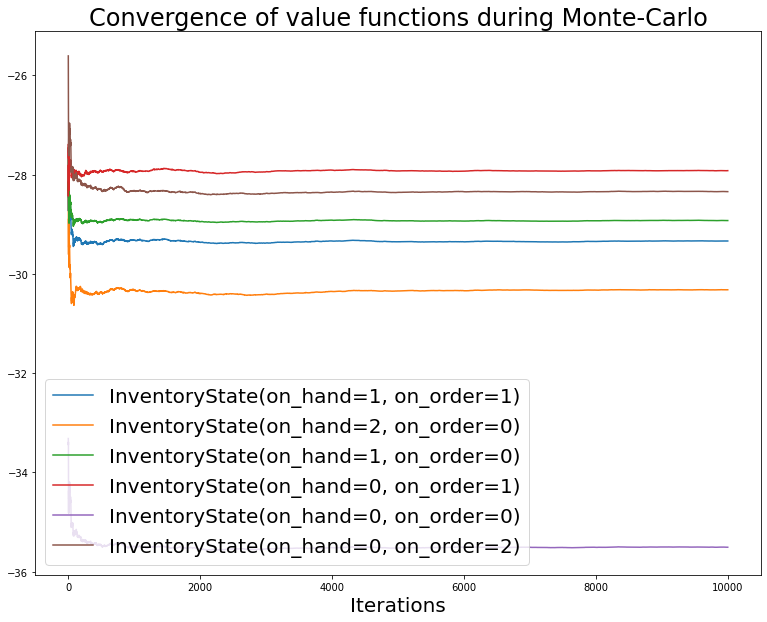

In [ ]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'Convergence of value functions during Monte-Carlo', fontsize=24)
for it in merged_dict.items():
  axs.plot(it[1], label=f'{it[0].state}')
axs.legend(fontsize=20);

Next we visualize the number of visits for each state during the operation of the Monte-Carlo algorithm.

In [ ]:
counts_dicts = [(vfa.counts_map) for vfa in vfa_lst]
# counts_dicts

In [ ]:
# https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
from collections import defaultdict
ds = counts_dicts
merged_dict = defaultdict(list)
for d in ds: #input dicts
    for key, value in d.items():
        merged_dict[key].append(value)
# merged_dict

In [ ]:
len(merged_dict)

6

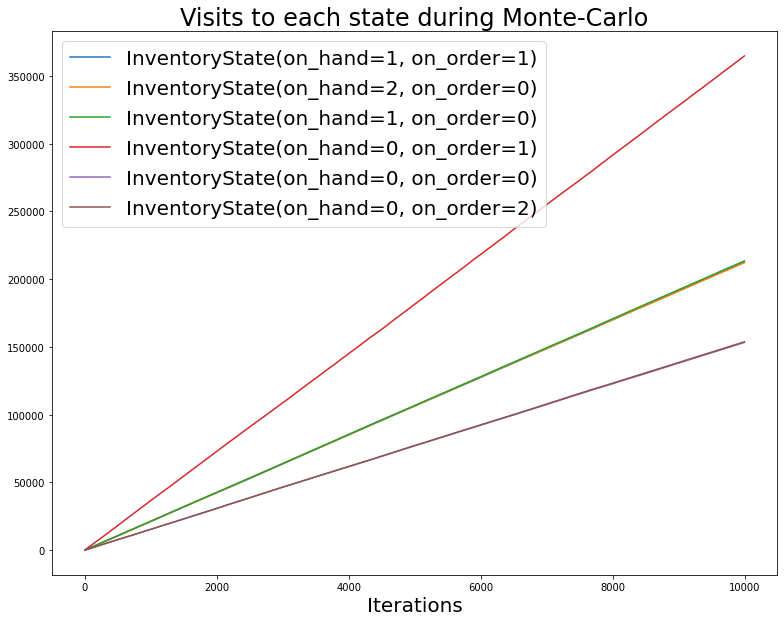

In [ ]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'Visits to each state during Monte-Carlo', fontsize=24)
for it in merged_dict.items():
  axs.plot(it[1], label=f'{it[0].state}')
axs.legend(fontsize=20);

In [ ]:
# hide
# INSTEAD OF MERGING DICTS
# for i,vfa in enumerate(vfa_lst):
#   for state in vfa.values_map:
#     print(i, state.state, vfa.values_map[state])

In [ ]:
# hide
# my_lst = \
# [
# [i, state.state, vfa.values_map[state]]
# for i,vfa in enumerate(vfa_lst)
# for state in vfa.values_map
# ]
# my_lst

In [ ]:
# hide
# vfa_i, states, values = zip(*my_lst)

In [ ]:
# hide
# vfa_i, states, values

In [ ]:
# hide
# LEGEND:
#   [Class]
#   <module/file>

# mc_finite_equal_wts_correctness() <prediction_utils>
#   mc_finite_prediction_equal_wts() <prediction_utils>
#     fmrp_episodes_stream() <prediction_utils>
#       mrp_episodes_stream() <prediction_utils>
#         reward_traces() <markov_process>[MarkovRewardProcess]
#     mc_prediction() <monte_carlo>
#       returns() <returns>
#         islice() <itertools>
#         accumulate() <iterate>
#           accumulate() <itertools>
#         islice() <itertools>
#       iterate_updates() <function_approx>[FunctionApprox]
#         accumulate() <itertools>
#       last() <iterate>
#   islice() <itertools>
#   last() <itertools>

In [ ]:
# hide
# plot_batch: int = 50
# plot_start: int = 0
# learning_rates: Sequence[Tuple[float, float, float]] = \
#     [(0.01, 100000, 0.5), (0.03, 1000, 0.5)]

In [ ]:
# hide
# %%time
# compare_td_and_mc(
#     fmrp=si_mrp,
#     gamma=gamma,
#     mc_episode_length_tol=mc_episode_length_tol,
#     num_episodes=num_episodes,
#     learning_rates=learning_rates,
#     initial_vf_dict=initial_vf_dict,
#     plot_batch=plot_batch,
#     plot_start=plot_start
# )